# Rules 
- Each player starts with a full deck of cards with Jokers, shuffled.
- One round is as follows: 
    - Players each place one card. 
    - Whoever is behind can choose to play or fold the trick to the other person.
- The first to 5 tricks wins the game. 

## Assumptions for model 

- If a player decides to play, they will play until the have a better hand than the opponent or run out of cards.
- Player does not remember the cards that have been played, except for jokers.

# MCTS Implementation

- One iteration of MCTS is as follows:
    - First card played for each player. 
    - Simulate the $\delta$ for the situation. Then, choice node over playable $\delta$. If the simulation is below the choice, play, if not fold. 
    - Store the $\delta$ chosen, as well as the game state at the time of the choice, and the game state after the choice.
    - it is now the other player's turn with the new game state. 
        - Question: is it a fair assumption to say that the cards on the board do not matter, just the amount of cards it would take to beat the other players hand?
        - If so, then the new game state if player1 plays is just the old game state with the number of cards left removed and jokers removed appropriately.
            - Might need to run GTO tacs here (if player1 plays, is it optimal for player2 to play, and in that case are you in a better situation than if you folded?)
        - Thinking this is yes.
    - Once an end state is reached, backpropagate the result by updating a value function (table mapping state, delta to value) 
        - When propogating back up, states should send back the maximum value of the $\delta$ choices.

- Run this for a while. Then there should be a lookup table of states and deltas to probability of winning. An optimal strategy can then be constructed from these. 

# Experiments Example
We plan to use the heuristic of a "card $\delta$" which is the number of extra cards a player must put down to win a trick. We thus must be able to evaluate states by simulating the number of cards it will take for our current hand to beat the opponent's hand. 
## Example 1: A vs 2
Player 1 has an A played, and player 2 has a 2 played. Both players have the other 53 cards available. How many cards does player 2 need to put down to win the trick? When playing in real life, it seems like a poor decision for player 2 to play. However, we see that actually player 2 only needs to put down 3 cards on average to win the trick. 

Let $X$ be the number of cards player 2 needs to put down to win the trick. We can calculate the distribution of $X$.
$$\text{P}(X = 1) = \frac{9}{53} = 0.170 \quad \text{(3 2s, 4 Aces, 2 Jokers)}$$
$$\text{P}(X = 2) = \frac{44}{53}\cdot \frac{12}{52} = 0.192 \quad \text{(one of 44 dead cards first, then one of 3 2s, 4 Aces, 2 Jokers)}$$
$$\text{P}(X = 3) = \frac{44}{53}\cdot \frac{40}{52}\cdot \frac{15}{51} = 0.188$$ 

and so on. We see that the simulated distribution of $X$ (shown below) perfectly matches the theoretical distribution.


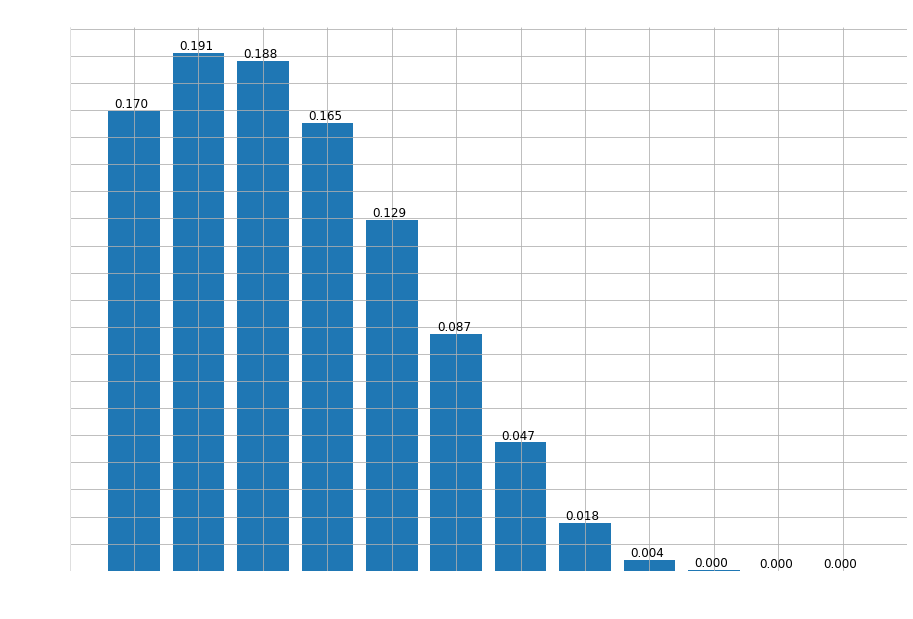

In [2]:
import matplotlib.pyplot as plt
# plot ./data/results.txt 

# set spines and ticks to white 
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
#set title nad axes labels to white
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlecolor'] = 'white'


def plot_results():
    with open('./data/results.txt', 'r') as f:
        lines = f.readlines()
        y = [float(line) for line in lines]
        cumsum = sum(y)
        y = [e / cumsum for e in y]

        x = list(range(len(y)))
        plt.figure(figsize=(15, 10))
        plt.plot(x[:13], y[:13])
        # add dots and labels for the first 10 points
        for i in range(13):
            plt.scatter(x[i], y[i], color='red')
            plt.text(x[i], y[i], f'{y[i]:.3f}', fontsize=12)
        # grid on with spacing 0.01 in y axis
        plt.grid()
        #set grid ticks to 0.01
        plt.yticks([i/100 for i in range(0, 21, 1)])
        plt.xticks([i for i in range(0, 13, 1)])

        
        plt.xlabel('X')
        plt.ylabel('P($X$)')
        plt.title('Probability of a 2 beating an A in $X$ tries')
        
        plt.show()

def plot_bar():
    with open('../data/results.txt', 'r') as f:
        lines = f.readlines()
        y = [float(line) for line in lines]
        cumsum = sum(y)
        y = [e / cumsum for e in y]

        x = list(range(len(y)))
        plt.figure(figsize=(15, 10))
        plt.bar(x[1:13], y[1:13])
        # add dots and labels for the first 10 points
        for i in range(1,13):
            plt.text(x[i]-0.3, y[i]+0.001, f'{y[i]:.3f}', fontsize=12)
        # grid on with spacing 0.01 in y axis
        plt.grid()
        #set grid ticks to 0.01
        plt.yticks([i/100 for i in range(0, 21, 1)])
        plt.xticks([i for i in range(0, 13, 1)])

        
        plt.xlabel('X')
        plt.ylabel('P($X$)')
        plt.title('Probability of a 2 beating an A in $X$ tries')
        
        plt.show()

if __name__ == '__main__':
    plot_bar()

## A better notion of the card $\delta$
It is not enough to simulate the number of cards needed to win a trick. Consider a situation where player 1 can play $x$ cards to win a trick. If this is a small number, we might think that it would be good to play. However, after player 1 plays those $x$ cards, if player 2 can play $x-1$ cards to retake the lead, then player 1 is back to a losing state, and has put down an extra card. Sometimes this might be good, for example if player 1 has a lot of cards left, and player 2 has few cards and player 1 wants to exhaust player 2's cards. However in general this would not be a good play and we want to consider these situations. 

The solution to this is to calculate $\delta_1$ the expected number of cards needed to be in the lead, and also $\delta_2$ the number of cards the opponent needs to play to retake the lead. If the difference $\delta_2 - \delta_1$ is positive, the opponent will need to play more cards than us to retake the lead. Thus we can win the trick in $\delta_1$ cards, or we will have gained a stack size on the opponent if they play. 

# Other Ideas

- "Value" of current hand as a function of the current made hand, draws, hero and villian cards remaining, hero and villian tricks won, Jokers remaining. 
    - Include weighted combination of "closeness" to certain hands -- less cards is better and weight should be higher for better hands (how do we parameterize this?)
- Policy iteration to find the optimal strategy for the hero to get to certain end game states, which can be solved by dynamic programming.
- Notes from 5/8 on value of a state
    - Weighted combination of the following heuristics
        - Remaining cards in stack
        - "Closeness" to each 5 card hand (weighted by the strength of the particular hand)
        - Jokers remaining
        - Tricks won